In [136]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import distance_matrix
from scipy.cluster.vq import kmeans

from sklearn.datasets import make_blobs

# Data 

In [86]:
def visualize_clusters(X, labels, seed=None):
    if seed is not None:
        np.random.seed(seed)
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[int(l)] for l in labels]
    plt.figure(figsize=(8, 8))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

In [73]:
def scatter_clusters(centers=None, spread=1.0, n_points=100, seed=None):
    return make_blobs(n_samples=n_points, centers=centers, cluster_std=spread, n_features=2, random_state=seed)

In [167]:
X, labels = scatter_clusters(seed=10)

# Kmeans

In [168]:
def kmeans_cluster_assignment(k, points, centers_guess=None, max_iterations=300, tolerance=1e-4, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    if centers_guess is None:
        centers_guess = np.random.uniform(points.min(axis=0), points.max(axis=0), size=(k, points.shape[1]))
    
    history = []
    
    for i in range(max_iterations):
        dists = distance_matrix(points, centers_guess)
        
        labels = np.argmin(dists, axis=1)

        new_centers = centers_guess.copy()
        for cluster in range(k):
            idxs = labels == cluster
            
            if idxs.sum() > 0:
                new_centers[cluster] = np.mean(X[idxs], axis=0)
                
        if np.linalg.norm(centers_guess - new_centers) < tolerance:
            break
            
        centers_guess = new_centers
        history.append(labels)
        
    return labels, np.array(history)

Основной недостаток Kmeans - инициализация начальных центроидов. Даже на простой задаче может случиться так, что два центра сьедут в одному кластеру, а оставшийся окажется между двумя остальными. Чтобы это поправить можно инициализировать центры с помощью точек из датасета, либо с помощью Kmeans++

Iterations: 2


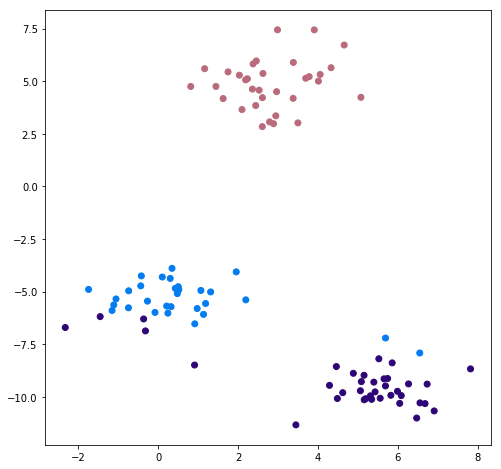

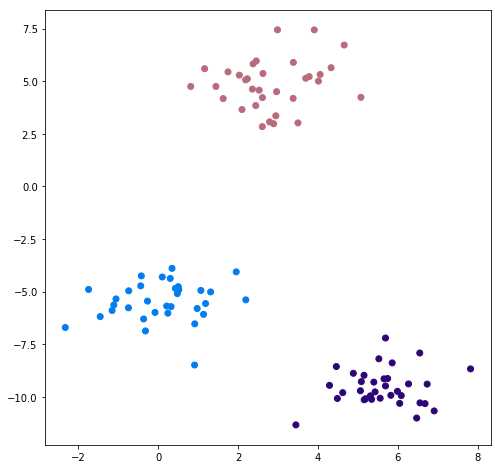

In [171]:
pred_labels, history = kmeans_cluster_assignment(3, X, tolerance=1e-8, seed=11)

print("Iterations:", len(history))

for h in history:
    visualize_clusters(X, h, seed=11)

# Evaluation

In [201]:
from sklearn.metrics import adjusted_rand_score

In [202]:
def scipy_kmeans(X, k):
    centroids, _ = kmeans(X, k)

    # O(n^2) ради лейблов, кек
    return distance_matrix(X, centroids).argmin(axis=1)

In [203]:
X, labels = scatter_clusters(n_points=20_000, seed=10)

Как видно, создатели scipy не сильно заморачивались над оптимизацией своих имлпементаций

In [204]:
%%timeit
scipy_kmeans(X, 3);

100 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [205]:
%%timeit
kmeans_cluster_assignment(3, X)

49.6 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Так как все метки перепутаны, для оценки качества используют Rand Index.

In [208]:
print("Scipy Rand score:", adjusted_rand_score(labels, scipy_kmeans(X, 3)))
print("Assignment Rand score:", adjusted_rand_score(labels, kmeans_cluster_assignment(3, X, seed=10)[0]))

Scipy Rand score: 0.9992502250262528
Assignment Rand score: 0.9992502250262528
